In [1]:
# Code reference: https://github.com/dennybritz/reinforcement-learning/tree/master/TD and https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/tree/master
import numpy as np
# import gymnasium as gym
import gym
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import copy

In [2]:
env = gym.make('CliffWalking-v0')
print(gym.__version__)
env.seed(0)
print(env.reset())
print(env.step(0))
print('State shape: ', env.observation_space.n)
print('Number of actions: ', env.action_space.n)

0.25.2
36
(24, -1, False, {'prob': 1.0})
State shape:  48
Number of actions:  4


/Users/keithwang/miniforge3_arm64/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/keithwang/miniforge3_arm64/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/keithwang/miniforge3_arm64/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/Users/keithwang/miniforge3_arm64/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: De

In [3]:
# Define MLP policy

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.

        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        # XXX NOTE: Commenting this line to avoid conflict with deepcopy
        # self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

In [4]:
class DuelingQNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.

        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(DuelingQNetwork, self).__init__()
        # XXX NOTE: Commenting this line to avoid conflict with deepcopy
        # self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, action_size)
        self.fc6 = nn.Linear(64, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        # advantage network
        a = self.fc3(x)
        a = F.relu(a)
        a = self.fc4(a)
        a = F.relu(a)
        a = self.fc5(a)
        # value network
        v = self.fc3(x)
        v = F.relu(v)
        v = self.fc4(v)
        v = F.relu(v)
        v = self.fc6(v)
        return v + a - a.mean()


### Define some hyperparameter

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network
CLONE_EVERY = int(1e4)  # how often to clone the q networks

In [6]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, state_size=48):
        """Initialize a ReplayBuffer object.

        Args:
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.state_size = state_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states, next_states = [], []
        for e in experiences:
          if e is not None:
            tensor = np.zeros(self.state_size)
            tensor1 = np.zeros(self.state_size)
            tensor[e.state] = 1
            tensor1[e.next_state] = 1
            states.append(tensor)
            next_states.append(tensor1)

        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Define Agent

In [8]:
class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, algo: str=None):
        """Initialize an Agent object.

        Args:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        if algo == 'duel_dqn':
            self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        else:
            self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def reset(self):
        for name, layer in self.qnetwork_local.named_children():
                # print(name)
                for n, l in layer.named_modules():
                    # print(n)
                    if hasattr(l, 'reset_parameters'):
                        # print(f'Reset trainable parameters of layer = {l}')
                        l.reset_parameters()
        
        for name, layer in self.qnetwork_target.named_children():
                # print(name)
                for n, l in layer.named_modules():
                    # print(n)
                    if hasattr(l, 'reset_parameters'):
                        # print(f'Reset trainable parameters of layer = {l}')
                        l.reset_parameters()

    def clone(self):
        try:
            del self.qnetwork_target
        except:
            pass

        self.qnetwork_target = copy.deepcopy(self.qnetwork_local)

        for p in self.qnetwork_target.parameters():
            p.requires_grad = False

        self.qnetwork_target = self.qnetwork_target.to(device)

    def step(self, state, action, reward, next_state, done, algo: str=None):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step += 1

        if self.t_step % UPDATE_EVERY == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA, algo)
        if self.t_step % CLONE_EVERY == 0:
            self.clone()


    def act(self, state, eps=0., eval=False):
        """Returns actions for given state as per current policy.

        Args:
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        tensor = torch.zeros(self.state_size).to(device)
        tensor[state] = 1
        state = tensor
        
        qnetwork = self.qnetwork_target if eval else self.qnetwork_local

        qnetwork.eval()
        with torch.no_grad():
            action_values = qnetwork(state)
        qnetwork.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma, algo: str=None):
        """Update value parameters using given batch of experience tuples.

        Args:
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences
        # Set the value at the specified index to 1
        
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        if algo == 'dqn':
            q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        elif algo == 'ddqn':
            actions_targets_next = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
            q_targets_next = self.qnetwork_target(next_states).detach().gather(1, actions_targets_next)
        else:
            q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Training Process

In [9]:
class train:
    def __init__(self, agent, env):
        self.agent = agent
        self.env = env
        self.num_episodes = 2000
        self.eval_every = 20
        self.n_epi_eval = 10

    def dqn(self, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, algo: str=None):
        """Deep Q-Learning.

        Args:
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        """
        episode_rewards = np.zeros(self.num_episodes)
        episode_rewards_eval = np.zeros(self.num_episodes // self.eval_every)

        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start                    # initialize epsilon
        for i_episode in range(1, self.num_episodes+1):
            state = self.env.reset()
            # state = env.step(0)[0]
            for t in range(max_t):
                action = self.agent.act(state, eps, algo)
                next_state, reward, done, _ = self.env.step(action)
                self.agent.step(state, action, reward, next_state, done, algo)
                state = next_state
                episode_rewards[i_episode-1] += reward
                if done:
                    break
            scores_window.append(episode_rewards[i_episode-1])       # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            # if np.mean(scores_window)>=-13:
            #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            #     torch.save(self.agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            #     break
            if i_episode % self.eval_every == 0:
                episode_rewards_eval[i_episode // self.eval_every - 1] = self.eval_performance(algo=algo)

        return episode_rewards, episode_rewards_eval
    
    def eval_performance(self, algo: None): # Q1.1> evaluate the learned policy by SARSA
        episode_rewards = np.zeros(self.n_epi_eval)
        for i_episode in range(self.n_epi_eval):
            # state = env.reset()[0]          # version 0.26.2
            state = env.reset()             # version 0.25.2
            action = self.agent.act(state, eps=0., eval=True)    
            for t in itertools.count():
                # next_state, reward, done, _, _ = env.step(action)       # version 0.26.2
                next_state, reward, done, _ = env.step(action)            # version 0.25.2
                episode_rewards[i_episode] += reward
                next_action = self.agent.act(next_state, eps=0., eval=True)
                if done or t > 1000:
                    break
                state = next_state
                action = next_action

        return np.mean(episode_rewards)

    def multi_run_experiment(self, n_runs, algo: str=None):
        if algo not in ["q_learning", "sarsa", "dqn", "ddqn", "duel_dqn"]:
            raise ValueError("Algo must be 'q_learning' or 'sarsa' or 'dqn' or 'ddqn' or 'duel_dqn'")
        self.agent.reset()
        episode_rewards_avg, episode_eval_rewards_avg = np.zeros(self.num_episodes), np.zeros(self.num_episodes // self.eval_every)

        for r in tqdm(range(n_runs)):
            if algo in ["q_learning", "sarsa"]:
                episode_rewards, episode_eval_rewards = self.q_learning() if algo == "q_learning" else self.sarsa()
            elif algo in ["dqn", "ddqn"]:
                episode_rewards, episode_eval_rewards = self.dqn(algo='dqn') if algo == "dqn" else self.dqn(algo='ddqn')
            elif algo == "duel_dqn":
                episode_rewards, episode_eval_rewards = self.dqn(algo='duel_dqn')
            episode_rewards_avg += episode_rewards
            episode_eval_rewards_avg += episode_eval_rewards
            self.agent.reset()

        episode_rewards_avg /= n_runs
        episode_eval_rewards_avg /= n_runs

        return episode_rewards_avg, episode_eval_rewards_avg


In [10]:
agent = DQNAgent(state_size=48, action_size=4, seed=0)
dqn_episode_rewards_avg, dqn_episode_eval_rewards_avg = train(agent, env).multi_run_experiment(n_runs=10, algo="dqn")

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 100	Average Score: -7852.39
Episode 200	Average Score: -1412.76
Episode 300	Average Score: -1744.57
Episode 400	Average Score: -256.10
Episode 500	Average Score: -831.97
Episode 600	Average Score: -33.07
Episode 700	Average Score: -24.01
Episode 800	Average Score: -16.59
Episode 900	Average Score: -15.25
Episode 1000	Average Score: -15.16
Episode 1100	Average Score: -15.34
Episode 1200	Average Score: -15.32
Episode 1300	Average Score: -15.16
Episode 1400	Average Score: -15.20
Episode 1500	Average Score: -17.40
Episode 1600	Average Score: -14.18
Episode 1700	Average Score: -16.26
Episode 1800	Average Score: -15.24
Episode 1900	Average Score: -20.42
Episode 2000	Average Score: -14.15
Episode 100	Average Score: -5154.95
Episode 200	Average Score: -534.51
Episode 300	Average Score: -208.69
Episode 400	Average Score: -96.85
Episode 500	Average Score: -435.95
Episode 600	Average Score: -163.31
Episode 700	Average Score: -26.19
Episode 800	Average Score: -19.65
Episode 900	Average Sco

In [11]:
ddqn_episode_rewards_avg, ddqn_episode_eval_rewards_avg = train(agent, env).multi_run_experiment(n_runs=10, algo="ddqn")

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 100	Average Score: -9103.56
Episode 200	Average Score: -1933.85
Episode 300	Average Score: -607.24
Episode 400	Average Score: -246.29
Episode 500	Average Score: -55.56
Episode 600	Average Score: -33.31
Episode 700	Average Score: -24.07
Episode 800	Average Score: -21.85
Episode 900	Average Score: -17.37
Episode 1000	Average Score: -16.24
Episode 1100	Average Score: -16.28
Episode 1200	Average Score: -14.34
Episode 1300	Average Score: -17.46
Episode 1400	Average Score: -13.16
Episode 1500	Average Score: -14.14
Episode 1600	Average Score: -15.21
Episode 1700	Average Score: -17.27
Episode 1800	Average Score: -14.16
Episode 1900	Average Score: -15.37
Episode 2000	Average Score: -16.29
Episode 100	Average Score: -6486.33
Episode 200	Average Score: -2797.77
Episode 300	Average Score: -765.98
Episode 400	Average Score: -336.12
Episode 500	Average Score: -190.00
Episode 600	Average Score: -43.57
Episode 700	Average Score: -33.72
Episode 800	Average Score: -23.95
Episode 900	Average Scor

In [12]:
agent = DQNAgent(state_size=48, action_size=4, seed=0, algo='duel_dqn')
duel_dqn_episode_rewards_avg, duel_dqn_episode_eval_rewards_avg = train(agent, env).multi_run_experiment(n_runs=10, algo="duel_dqn")

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 100	Average Score: -3733.32
Episode 200	Average Score: -167.39
Episode 300	Average Score: -72.39
Episode 400	Average Score: -31.83
Episode 500	Average Score: -27.25
Episode 600	Average Score: -31.64
Episode 700	Average Score: -20.84
Episode 800	Average Score: -19.52
Episode 900	Average Score: -16.17
Episode 1000	Average Score: -16.12
Episode 1100	Average Score: -16.31
Episode 1200	Average Score: -16.21
Episode 1300	Average Score: -19.25
Episode 1400	Average Score: -16.28
Episode 1500	Average Score: -15.18
Episode 1600	Average Score: -15.31
Episode 1700	Average Score: -15.18
Episode 1800	Average Score: -14.23
Episode 1900	Average Score: -14.22
Episode 2000	Average Score: -17.32
Episode 100	Average Score: -3641.94
Episode 200	Average Score: -869.71
Episode 300	Average Score: -108.03
Episode 400	Average Score: -79.89
Episode 500	Average Score: -43.89
Episode 600	Average Score: -24.37
Episode 700	Average Score: -23.09
Episode 800	Average Score: -22.75
Episode 900	Average Score: -17

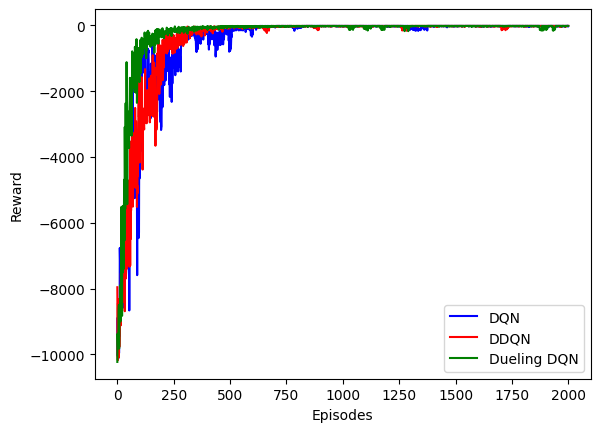

In [15]:
plt.plot(dqn_episode_rewards_avg, label='DQN', color='blue')
plt.plot(ddqn_episode_rewards_avg, label='DDQN', color='red')
plt.plot(duel_dqn_episode_rewards_avg, label='Dueling DQN', color='green')
plt.xlabel('Episodes')
plt.ylabel('Reward')
# plt.ylim([-1000, 0])
plt.legend()

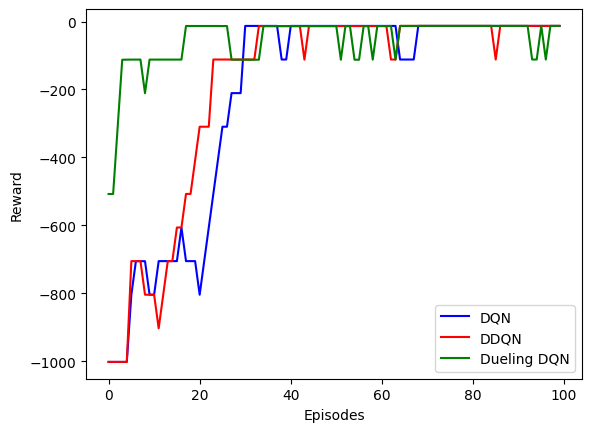

In [16]:
plt.plot(dqn_episode_eval_rewards_avg, label='DQN', color='blue')
plt.plot(ddqn_episode_eval_rewards_avg, label='DDQN', color='red')
plt.plot(duel_dqn_episode_eval_rewards_avg, label='Dueling DQN', color='green')
plt.xlabel('Episodes')
plt.ylabel('Reward')
# plt.ylim([-1000, 0])
plt.legend()

## Comment

### Performance Comparison of Reinforcement Learning Algorithms

DQN, DDQN, and Dueling-DQN all run with parameters 2000 episodes, 1000 max steps for each episode, and the performance was the mean of the rewards of 10 times training.
DQN: 13m38.6s; DDQN: 13m18.3s; Dueling-DQN: 8m34.0s

#### 1. Number of Steps and Episodes
- **Tabular Q-learning and SARSA**: Efficient in simple environments with small state spaces. Each step directly updates the Q-table, but inefficient in large state spaces due to the need for an entry for each state-action pair. In this environment, need small steps and episodes to converge though tested with 1000 steps and 2000 episodes for the performance comparison reason.
- **DQN, Double-DQN, and Dueling-DQN**: Suitable for large state spaces, leveraging neural networks for state generalization. May require more samples for effective policy learning. DQN and Double-DQN need more episodes than Dueling-DQN. 

#### 2. Number of Gradient Steps
- **Tabular Methods**: Do not use gradient steps as they update a Q-table directly.
- **DQN and Variants**: Involve significant gradient descent steps to update neural network weights, particularly in complex environments.

#### 3. Memory Requirements
- **Tabular Q-learning and SARSA**: Memory usage is proportional to the size of the state-action space, problematic in large or continuous spaces.
- **DQN, Double-DQN, and Dueling-DQN**: Higher memory requirements due to neural network parameters and the replay buffer for storing past experiences.

#### 4. Stability and Convergence
- **Tabular Q-learning and SARSA**: Generally stable in simple environments. Sum of rewards converged faster than Q Network algorithms while neither of them reached the best reward or close enough to -13.
- **DQN**: Prone to instable and converge slowly, approximately reach at -13.
- **Double-DQN**: Prone to less instable and converge less slowly, approximately reach at -13.
- **Dueling-DQN**: Prone to stable and converge faster, approximately reach at -13.

#### 5. Training Time and Complexity
- **Tabular Methods**: Faster training in simple environments; infeasible in larger spaces.
- **DQN, Double-DQN, and Dueling-DQN**: Require more computational resources and time due to deep neural networks. I tried use more parameters in the network and received a better performance on convergence. The training time stayed still as the convergence happened sooner while the parameters were more so needed more time to update. It is a trade-off. 

#### 6. Robustness
- **Tabular Methods**: More robust in small, well-defined environments but the performance is under the expectation compared to the idealistic result.
- **DQN Variants**: Improved robustness in diverse environments but sensitive to hyperparameters and network architecture. Reach to the optimal reward in the end.

**Summary**: Tabular methods are suited for simple, discrete environments when training time is highly restricted, while DQN and its variants are preferred for complex, high-dimensional, or continuous spaces and cost more training time. 
